[*********************100%***********************]  1 of 1 completed


Price        Date       Open       High        Low      Close   Volume
Ticker               NHPC.NS    NHPC.NS    NHPC.NS    NHPC.NS  NHPC.NS
0      2015-01-01  10.999075  11.175530  10.999075  11.116712  1950452
1      2015-01-02  11.116712  11.293169  11.116712  11.204940  3189435
2      2015-01-05  11.204939  11.263758  11.116712  11.116712  1847875
3      2015-01-06  11.087302  11.087302  10.822618  10.881436  3339702
4      2015-01-07  10.940255  10.969663  10.675571  10.734389  3502444


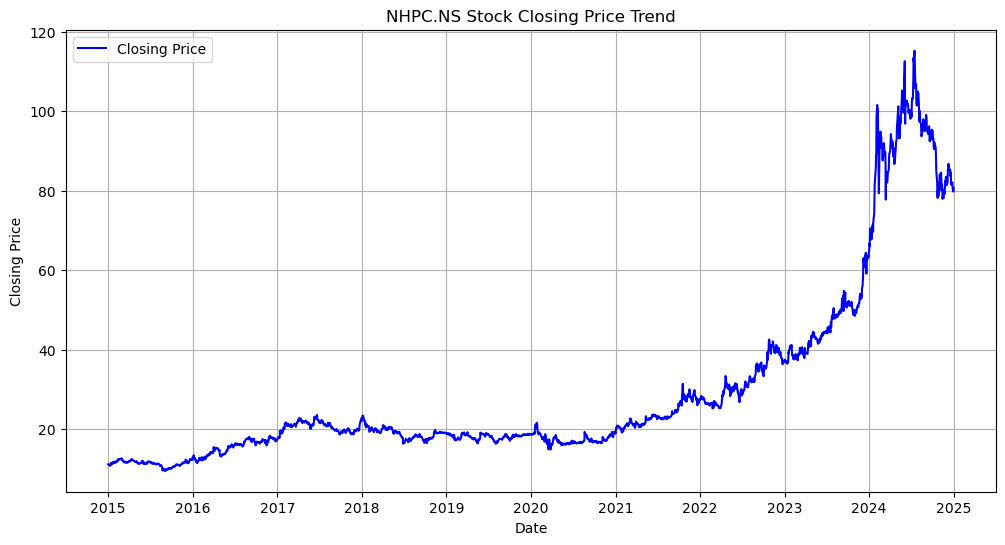

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# Function to fetch historical stock data
def fetch_stock_data(ticker, start_date, end_date):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        
        if stock_data.empty:
            raise ValueError(f"No data found for ticker: {ticker}")
        
        stock_data.reset_index(inplace=True)
        
        # Select necessary columns
        df = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        print(df.head())

        return df

    except Exception as e:
        print(f"Error: {e}")
        return None

# Fetch data for stock 
ticker = "NHPC.NS"
start_date = "2015-01-01"
end_date = "2025-01-01"

df = fetch_stock_data(ticker, start_date, end_date)

# Plot stock closing price trend
if df is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Close'], label='Closing Price', color='blue')
    plt.title(f'{ticker} Stock Closing Price Trend')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()



X_train_lstm shape: (1925, 60)
y_train_lstm shape: (1925,)
X_test_lstm shape: (482, 60)
y_test_lstm shape: (482,)


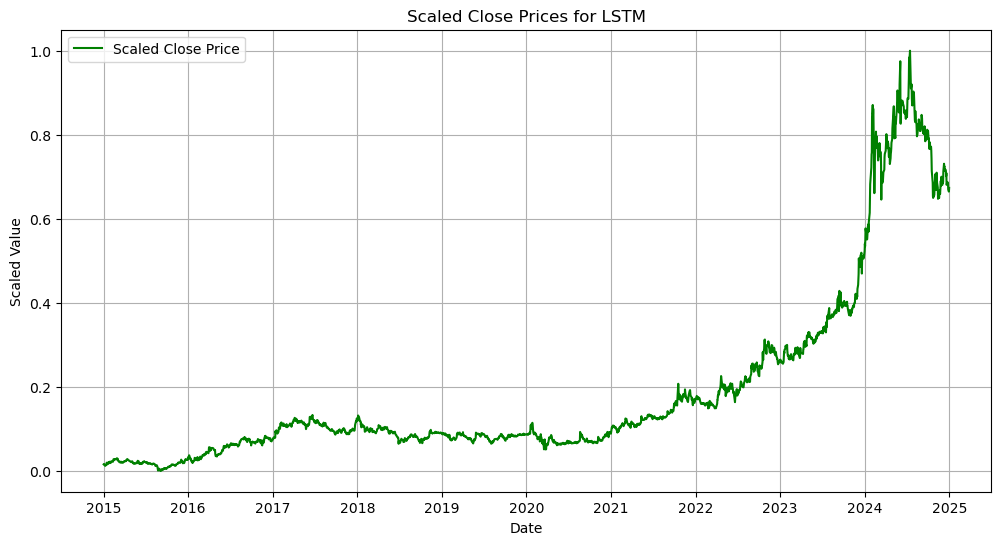

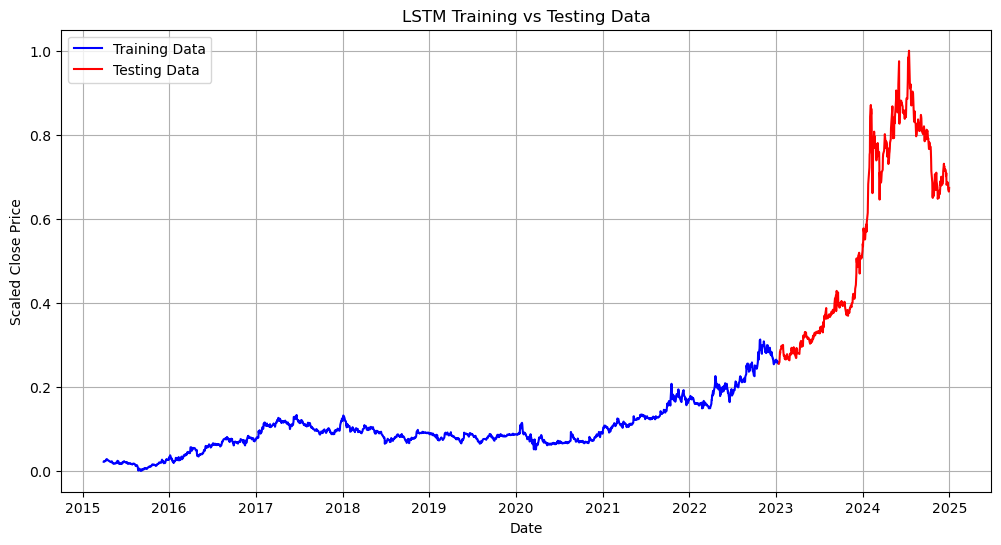

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Scale the 'Close' prices for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])  # Use .loc to avoid warning

# Function to create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 60
X_lstm, y_lstm = create_sequences(df['Close_Scaled'].values, sequence_length)

# Split data into training and testing sets (80% training, 20% testing)
split_idx = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# Print shapes for verification
print(f"X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")
print(f"X_test_lstm shape: {X_test_lstm.shape}")
print(f"y_test_lstm shape: {y_test_lstm.shape}")

# Visualization: Scaled Close prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close_Scaled'], label='Scaled Close Price', color='green')
plt.title('Scaled Close Prices for LSTM')
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid()
plt.show()

# Visualization: Training vs Testing split
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][sequence_length:split_idx + sequence_length], y_train_lstm, label='Training Data', color='blue')
plt.plot(df['Date'][split_idx + sequence_length:], y_test_lstm, label='Testing Data', color='red')
plt.title('LSTM Training vs Testing Data')
plt.xlabel('Date')
plt.ylabel('Scaled Close Price')
plt.legend()
plt.grid()
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
61/61 [==============================] - 

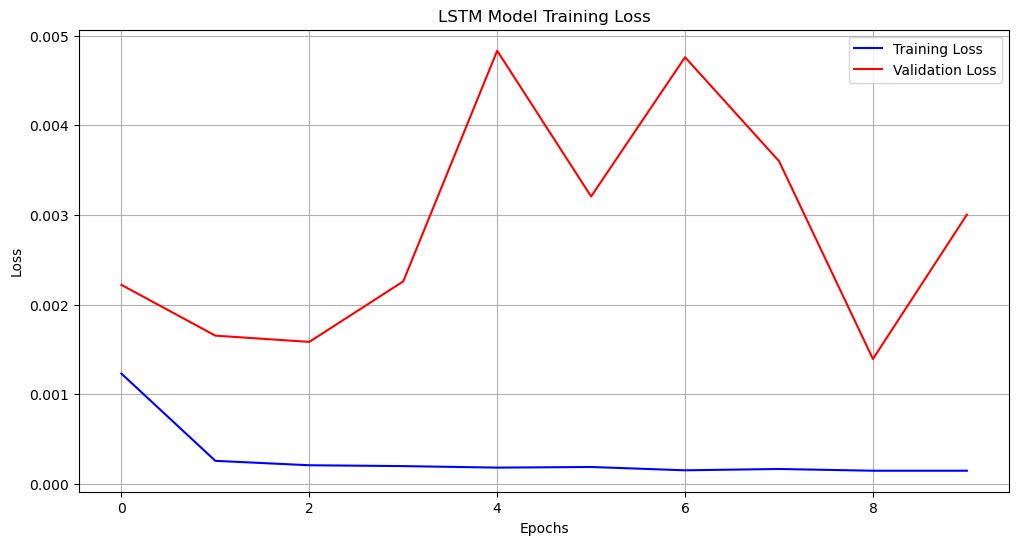

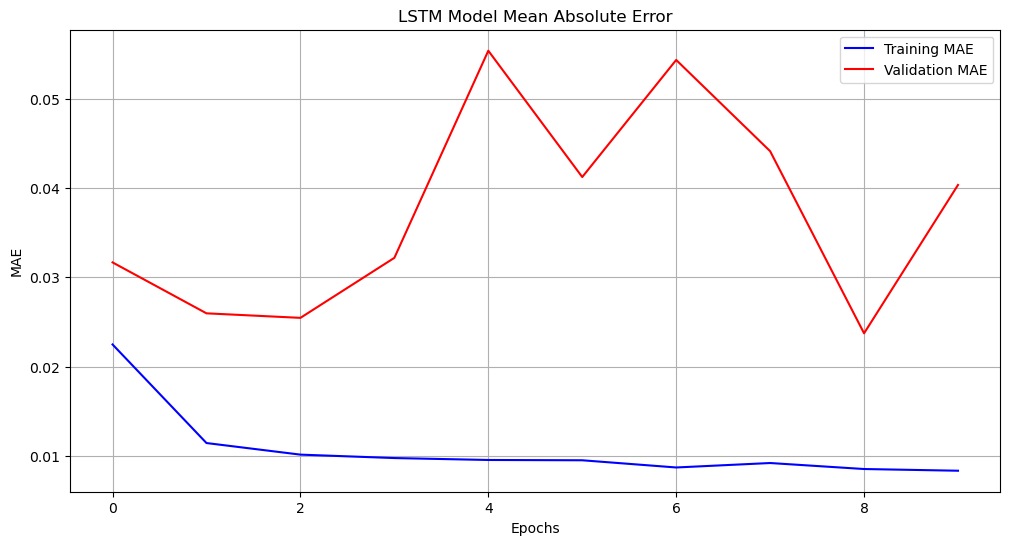

76/76 [==============================] - 2s 15ms/step


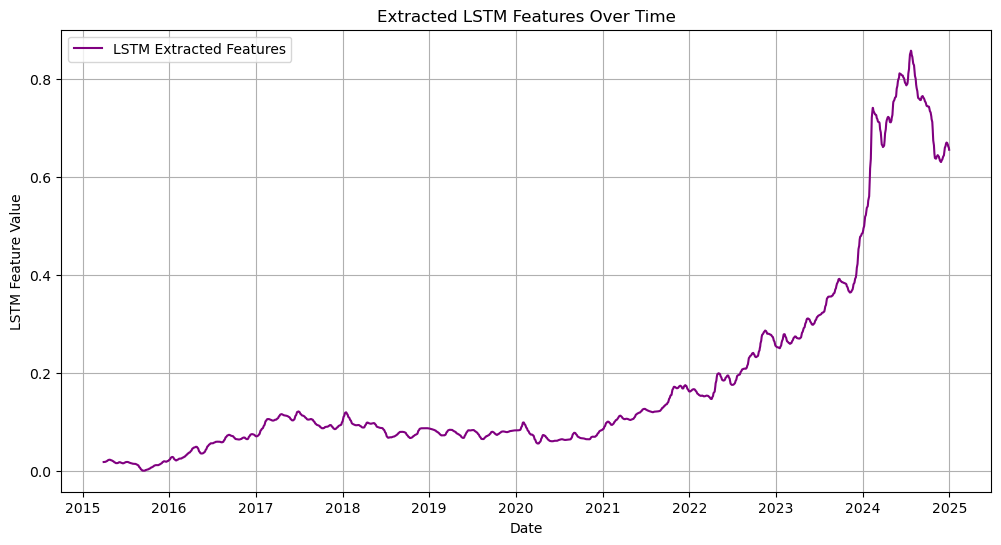

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Ensure reproducibility
np.random.seed(42)

# Define the LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1), activation='tanh'),
    Dropout(0.2),  # Add dropout for regularization
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1, activation='linear')  # Output layer
])

# Compile the LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

# Print model summary
lstm_model.summary()

# Train the LSTM model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm, 
    epochs=10,  # Increased epochs for better learning
    batch_size=32, 
    validation_data=(X_test_lstm, y_test_lstm), 
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE', color='blue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
plt.title('LSTM Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

# Extract LSTM features
lstm_features = lstm_model.predict(X_lstm)

# Ensure a copy of the DataFrame is explicitly used
df = df.copy()

# Initialize the LSTM features column in the DataFrame
df['LSTM_Features'] = np.nan  # Avoid SettingWithCopyWarning

# Fix the alignment issue by matching lengths
if len(lstm_features.flatten()) == len(df) - sequence_length - 1:
    df.loc[sequence_length + 1:, 'LSTM_Features'] = lstm_features.flatten()
elif len(lstm_features.flatten()) == len(df) - sequence_length:
    df.loc[sequence_length:, 'LSTM_Features'] = lstm_features.flatten()
else:
    raise ValueError(
        f"Mismatch in lengths: LSTM features ({len(lstm_features.flatten())}) "
        f"and DataFrame rows after sequence_length ({len(df) - sequence_length})."
    )

# Plot the extracted LSTM features
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][sequence_length:], df['LSTM_Features'][sequence_length:], label='LSTM Extracted Features', color='purple')
plt.title('Extracted LSTM Features Over Time')
plt.xlabel('Date')
plt.ylabel('LSTM Feature Value')
plt.legend()
plt.grid()
plt.show()


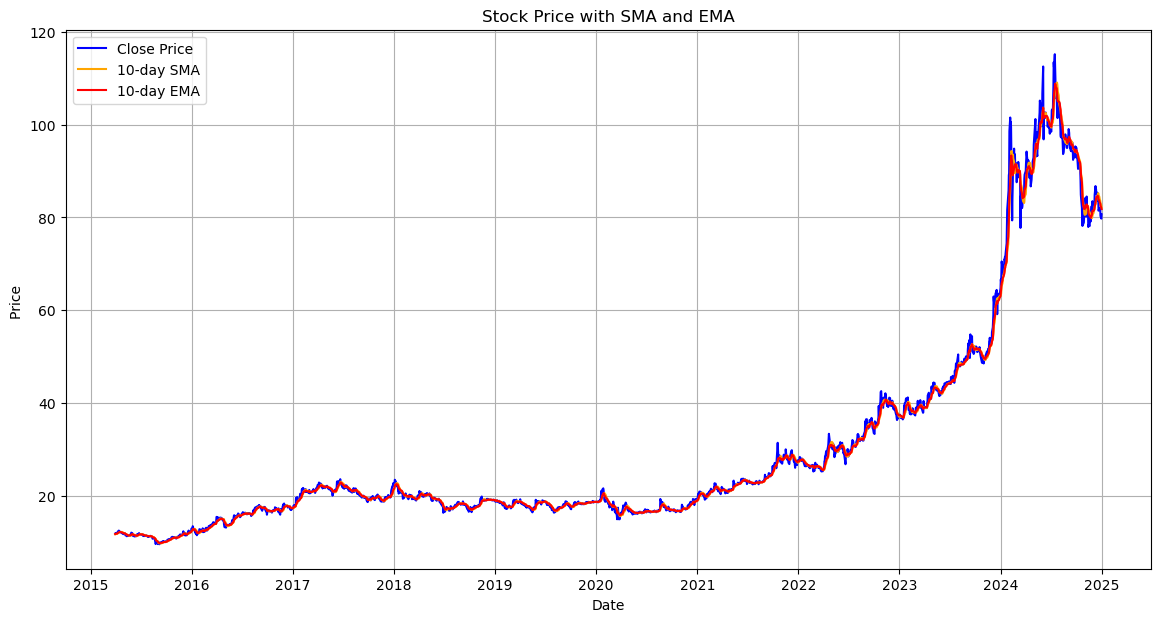

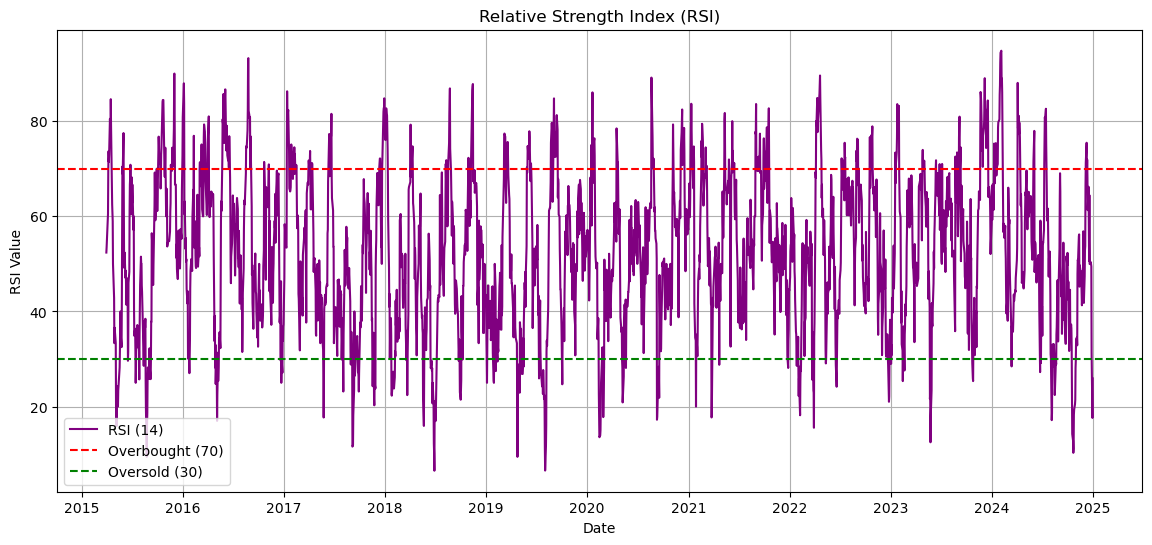

In [4]:
import matplotlib.pyplot as plt

# Add Simple Moving Average (SMA) and Exponential Moving Average (EMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['EMA_10'] = df['Close'].ewm(span=10).mean()

# Function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Add RSI to the DataFrame
df['RSI'] = calculate_rsi(df['Close'])

# Drop NaN rows (due to rolling calculations)
df.dropna(inplace=True)

# Visualization: Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.plot(df['Date'], df['SMA_10'], label='10-day SMA', color='orange')
plt.plot(df['Date'], df['EMA_10'], label='10-day EMA', color='red')
plt.title('Stock Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price ')
plt.legend()
plt.grid()
plt.show()

# Visualization: RSI Indicator
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['RSI'], label='RSI (14)', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend()
plt.grid()
plt.show()


X_train_xgb shape: (1925, 5)
X_test_xgb shape: (482, 5)
y_train_xgb shape: (1925, 1)
y_test_xgb shape: (482, 1)


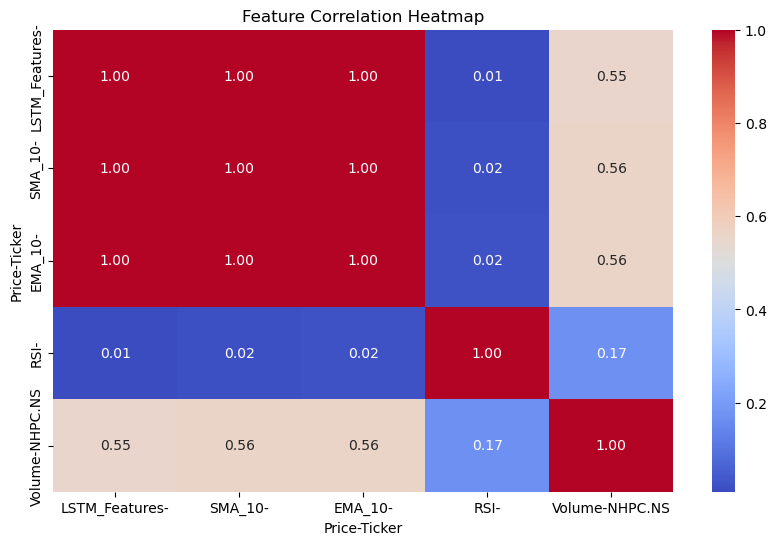

In [5]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare features and target for Gradient Boosting model
features = ['LSTM_Features', 'SMA_10', 'EMA_10', 'RSI', 'Volume']

# Ensure no missing values in selected features
X_xgb = df[features].dropna()
y_xgb = df.loc[X_xgb.index, 'Close']

# Check for data availability before splitting
if X_xgb.shape[0] == 0:
  print("Error: No data available for train-test split. Please check your dataframe.")
else:
  # Adjust test size if necessary (e.g., reduce to 0.1 for limited data)
  test_size = min(0.2, 1 - 1/X_xgb.shape[0])  # Ensure test size is less than 1 - 1/n_samples

  # Train-test split 
  X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
      X_xgb, y_xgb, test_size=test_size, random_state=42
  )

  # Print dataset shapes for verification
  print(f"X_train_xgb shape: {X_train_xgb.shape}")
  print(f"X_test_xgb shape: {X_test_xgb.shape}")
  print(f"y_train_xgb shape: {y_train_xgb.shape}")
  print(f"y_test_xgb shape: {y_test_xgb.shape}")

  # Visualizing feature correlations using a heatmap
  plt.figure(figsize=(10, 6))
  correlation_matrix = X_xgb.corr()
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  plt.title('Feature Correlation Heatmap')
  plt.show()

c:\Users\anish\anaconda3\envs\python1\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost RMSE: 0.69
XGBoost R² Score: 1.00


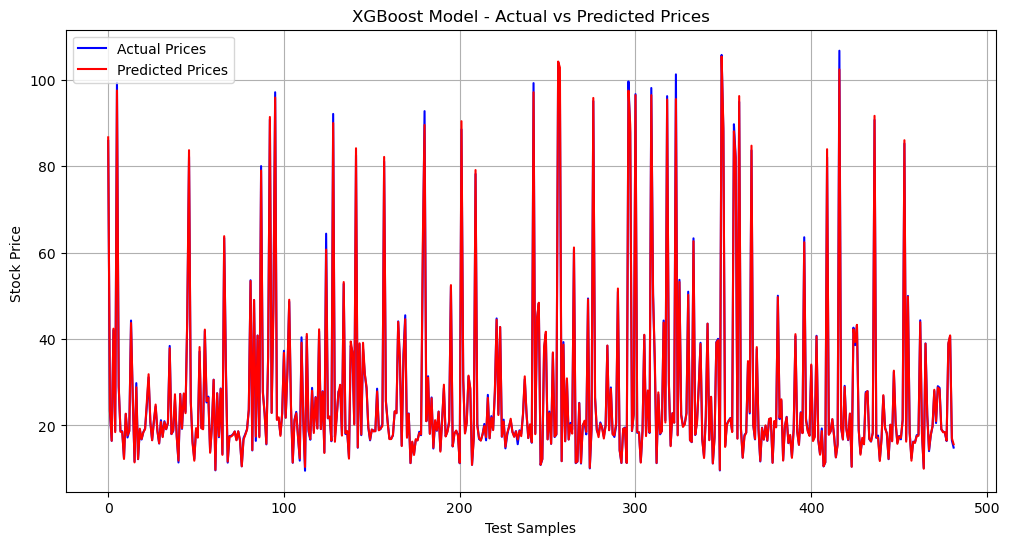

<Figure size 1000x600 with 0 Axes>

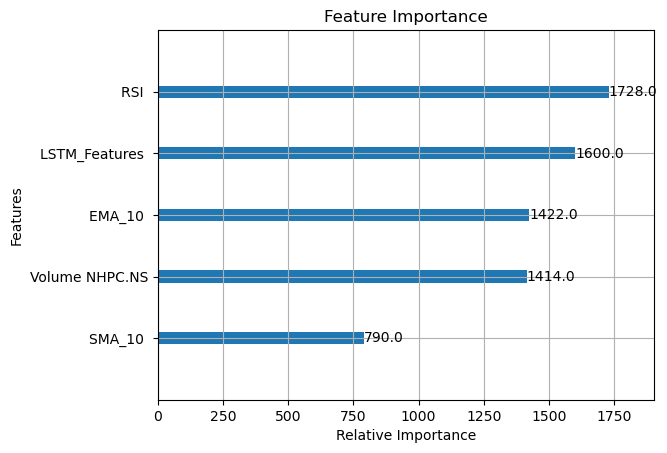

In [6]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Train the XGBoost model with optimal parameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,       # Increased for better learning
    learning_rate=0.05,     # Reduced to improve generalization
    max_depth=6, 
    subsample=0.8,          # To reduce overfitting
    colsample_bytree=0.8,   # To add randomness
    random_state=42
)

xgb_model.fit(X_train_xgb, y_train_xgb)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test_xgb)
rmse = mean_squared_error(y_test_xgb, y_pred_xgb, squared=False)
r2 = r2_score(y_test_xgb, y_pred_xgb)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R² Score: {r2:.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_xgb.values, label='Actual Prices', color='blue')
plt.plot(y_pred_xgb, label='Predicted Prices', color='red')
plt.title('XGBoost Model - Actual vs Predicted Prices')
plt.xlabel('Test Samples')
plt.ylabel('Stock Price ')
plt.legend()
plt.grid()
plt.show()

# Feature importance visualization
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', title='Feature Importance', xlabel='Relative Importance')
plt.show()

In [7]:
import joblib
from tensorflow.keras.models import load_model

# Save the LSTM model in HDF5 format
lstm_model.save('lstm_model.h5')
print("LSTM model saved successfully as 'lstm_model.h5'.")

# Save the XGBoost model using joblib
joblib.dump(xgb_model, 'xgb_model.pkl')
print("XGBoost model saved successfully as 'xgb_model.pkl'.")

# Validation: Load and test models
try:
    # Load LSTM model to check if it was saved correctly
    loaded_lstm_model = load_model('lstm_model.h5')
    print("LSTM model loaded successfully.")

    # Load XGBoost model to verify serialization
    loaded_xgb_model = joblib.load('xgb_model.pkl')
    print("XGBoost model loaded successfully.")
except Exception as e:
    print(f"Error loading models: {e}")

LSTM model saved successfully as 'lstm_model.h5'.
XGBoost model saved successfully as 'xgb_model.pkl'.
LSTM model loaded successfully.
XGBoost model loaded successfully.


1/1 [==============================] - 1s 887ms/step
Predicted Closing Price: 73.82


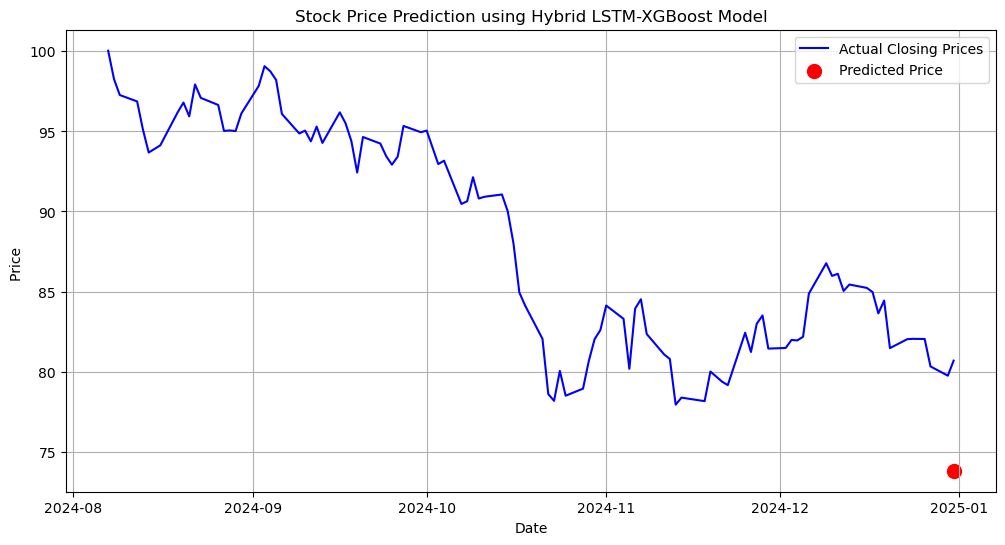

In [8]:
import numpy as np

# Prepare the last sequence of scaled close prices for LSTM prediction
new_data = df[['Close_Scaled']].values[-sequence_length:]
new_data = new_data.reshape(1, sequence_length, 1)  # Reshape for LSTM input

# Predict LSTM features for the new data
new_lstm_features = lstm_model.predict(new_data)

# Prepare the latest feature set for XGBoost prediction
new_xgb_input = df[['SMA_10', 'EMA_10', 'RSI', 'Volume']].iloc[-1].copy()  # Copy to avoid SettingWithCopyWarning
new_xgb_input['LSTM_Features'] = new_lstm_features[-1, 0]  # Add LSTM extracted feature

# Reshape input for XGBoost and make a final prediction
final_prediction = xgb_model.predict(new_xgb_input.values.reshape(1, -1))
predicted_price = final_prediction[0]

print(f"Predicted Closing Price: {predicted_price:.2f}")

# Visualization: Compare actual vs predicted value
plt.figure(figsize=(12, 6))
plt.plot(df['Date'].iloc[-100:], df['Close'].iloc[-100:], label='Actual Closing Prices', color='blue')
plt.scatter(df['Date'].iloc[-1], predicted_price, color='red', label='Predicted Price', marker='o', s=100)
plt.title('Stock Price Prediction using Hybrid LSTM-XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Price ')
plt.legend()
plt.grid()
plt.show()
